Shape: (614, 13)

Columns and dtypes:
 Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

First 5 rows:
     Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0 

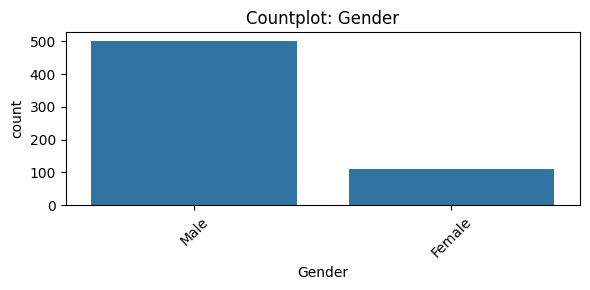

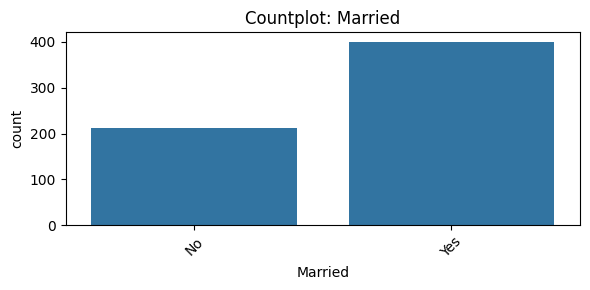

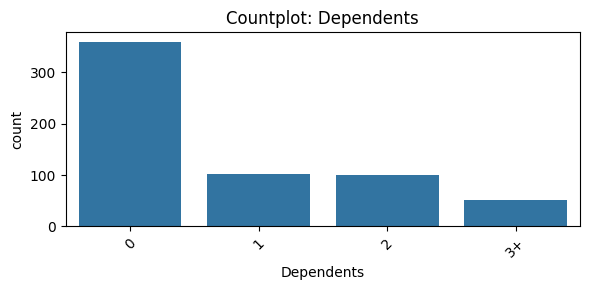

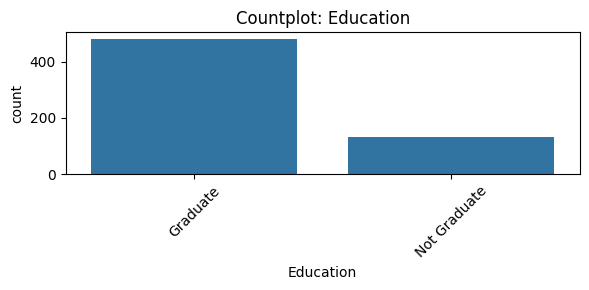

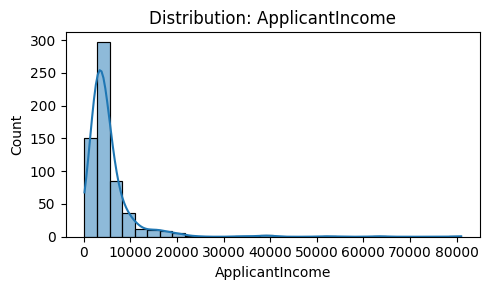

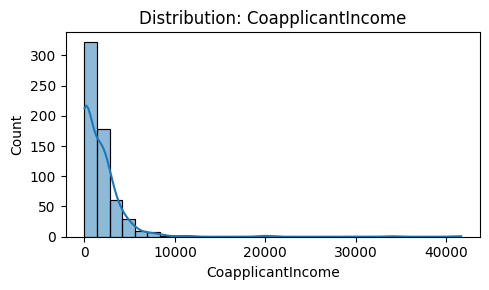

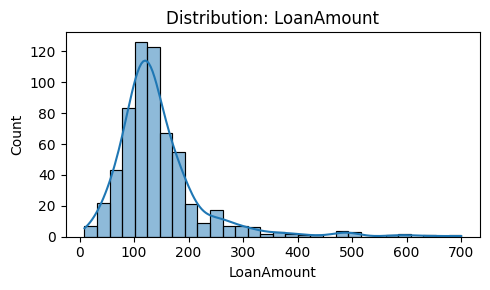

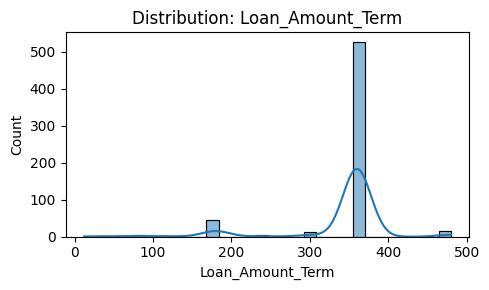

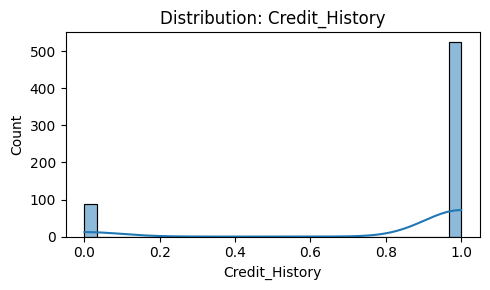

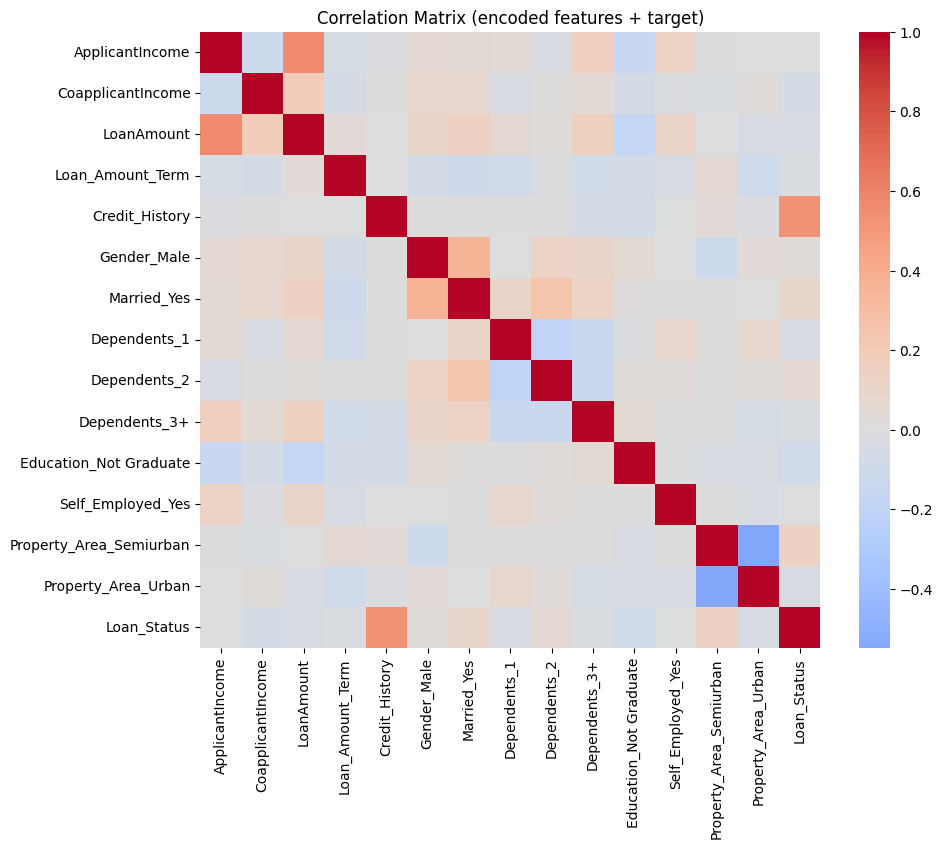


Top features by absolute correlation with target:
 Credit_History             0.540556
Property_Area_Semiurban    0.136540
Married_Yes                0.091478
Education_Not Graduate     0.085884
Dependents_2               0.062384
CoapplicantIncome          0.059187
Property_Area_Urban        0.043621
Dependents_1               0.038740
LoanAmount                 0.033214
Dependents_3+              0.026123
Loan_Amount_Term           0.022549
Gender_Male                0.017987
ApplicantIncome            0.004710
Self_Employed_Yes          0.003700
Name: Loan_Status, dtype: float64

Train shape: (429, 14) Test shape: (185, 14)
Train target distribution:
 Loan_Status
1    0.687646
0    0.312354
Name: proportion, dtype: float64
Test target distribution:
 Loan_Status
1    0.686486
0    0.313514
Name: proportion, dtype: float64

Model Evaluation:
Accuracy: 0.8541
Precision: 0.8378
Recall: 0.9764
F1 Score: 0.9018

Confusion Matrix:
 [[ 34  24]
 [  3 124]]

Classification Report:
          

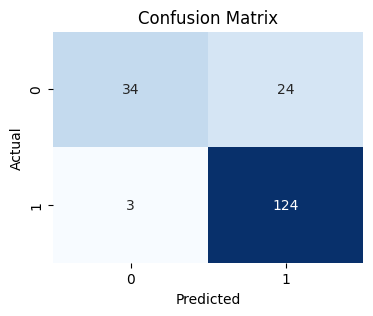


Top positive coefficients (increase probability of approval):
                     Feature  Coefficient
4            Credit_History     1.194835
12  Property_Area_Semiurban     0.395652
6               Married_Yes     0.262632
8              Dependents_2     0.233018
9             Dependents_3+     0.116588
13      Property_Area_Urban     0.089809
0           ApplicantIncome     0.035851
3          Loan_Amount_Term    -0.009321
5               Gender_Male    -0.030274
2                LoanAmount    -0.047998
11        Self_Employed_Yes    -0.078145
1         CoapplicantIncome    -0.113625
7              Dependents_1    -0.143328
10   Education_Not Graduate    -0.208019

Top negative coefficients (decrease probability of approval):
                     Feature  Coefficient
4            Credit_History     1.194835
12  Property_Area_Semiurban     0.395652
6               Married_Yes     0.262632
8              Dependents_2     0.233018
9             Dependents_3+     0.116588
13      Pro

In [1]:
# Part A: Full pipeline for Loan Approval (Logistic Regression)

# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# 1. Load the dataset and inspect
df = pd.read_csv("train.csv")   # <-- change filename if needed

print("Shape:", df.shape)
print("\nColumns and dtypes:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

# 2. Data cleaning: missing values, encode categoricals, drop irrelevant features

# 2.1 Show missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Example: drop an ID column if present
irrelevant_cols = []
for c in ["Loan_ID", "ID", "Applicant_ID"]:
    if c in df.columns:
        irrelevant_cols.append(c)

if irrelevant_cols:
    print("\nDropping irrelevant columns:", irrelevant_cols)
    df = df.drop(columns=irrelevant_cols)

# 2.2 Basic filling strategy (customize as needed)
# For categorical columns: fill with mode
# For numeric columns: fill with median
for col in df.columns:
    if df[col].dtype == "object":
        # Keep NaNs for target (if any) until later; but fill for features:
        if col != "Loan_Status":
            df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

print("\nMissing values after imputation:\n", df.isnull().sum())

# 2.3 Optionally map target to 0/1 if it's categorical like 'Y'/'N'
target_col = "Loan_Status"   # change if your dataset uses different name
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")

# Common encodings: 'Y'/'N' -> 1/0 or 'Approved'/'Rejected'
if df[target_col].dtype == "object":
    unique_targets = sorted(df[target_col].dropna().unique())
    print("\nTarget unique values:", unique_targets)
    # Try common mappings
    if set(unique_targets) <= {"Y","N"}:
        df[target_col] = df[target_col].map({"Y":1, "N":0})
    elif set([u.lower() for u in unique_targets]) <= {"yes","no"}:
        df[target_col] = df[target_col].str.lower().map({"yes":1,"no":0})
    elif set([u.lower() for u in unique_targets]) <= {"approved","rejected"}:
        df[target_col] = df[target_col].str.lower().map({"approved":1,"rejected":0})
    else:
        # As fallback, create a numeric label mapping
        mapping = {v:i for i,v in enumerate(unique_targets)}
        print("Mapping target with:", mapping)
        df[target_col] = df[target_col].map(mapping)

print(f"\nAfter mapping, target value counts:\n{df[target_col].value_counts(dropna=False)}")

# 2.4 Separate features and (temporary) target to avoid accidental encoding of target
X_raw = df.drop(columns=[target_col])
y = df[target_col].astype(int)   # ensure integer 0/1

# 2.5 Encode categorical variables using one-hot (drop_first=True to avoid collinearity)
cat_cols = X_raw.select_dtypes(include="object").columns.tolist()
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

X_encoded = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

print("\nFeature set after encoding shape:", X_encoded.shape)
print("Encoded feature columns (first 20):\n", X_encoded.columns.tolist()[:20])

# 3. EDA: summary stats, histograms/countplots, correlation heatmap

# 3.1 Summary statistics
print("\nNumeric summary:\n", X_raw.describe(include=[np.number]).T)

# 3.2 Countplots for a few categorical columns (if exist)
if len(cat_cols) > 0:
    for col in cat_cols[:4]:   # plot up to first 4 categorical columns
        plt.figure(figsize=(6,3))
        sns.countplot(x=col, data=X_raw)
        plt.title(f"Countplot: {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 3.3 Histograms for numeric columns (first 6)
for col in num_cols[:6]:
    plt.figure(figsize=(5,3))
    sns.histplot(X_raw[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution: {col}")
    plt.tight_layout()
    plt.show()

# 3.4 Correlation heatmap (use encoded numeric features; show top correlated with target separately)
plt.figure(figsize=(10,8))
corr = pd.concat([X_encoded, y], axis=1).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (encoded features + target)")
plt.show()

# Show top features correlated with target
target_corr = corr[target_col].drop(target_col).abs().sort_values(ascending=False)
print("\nTop features by absolute correlation with target:\n", target_corr.head(15))

# 4. Define target (y) and independent variables (X) — already done (X_encoded, y)

# 5. Train-test split 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.30, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

# 5.1 Scale numeric features (scaling all features is fine because encoded dummies are 0/1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train Logistic Regression
lr = LogisticRegression(max_iter=1000, solver="liblinear")   # liblinear is fine for small datasets
lr.fit(X_train_scaled, y_train)

# 7. Predictions on test set
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:,1]

# 8. Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Visualize confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 9. Interpret coefficients: which features influence loan approval most strongly?
# Because we scaled features, coefficients are comparable.
coeffs = lr.coef_[0]
features_names = X_encoded.columns
coef_df = pd.DataFrame({
    "Feature": features_names,
    "Coefficient": coeffs
}).sort_values(by="Coefficient", ascending=False)

print("\nTop positive coefficients (increase probability of approval):\n", coef_df.head(15))
print("\nTop negative coefficients (decrease probability of approval):\n", coef_df.tail(15))

# For readability show absolute impact
coef_df["abs_coef"] = coef_df["Coefficient"].abs()
print("\nTop features by absolute coefficient:\n", coef_df.sort_values(by="abs_coef", ascending=False).head(20))

# Optional: show odds ratios (exp(coef))
coef_df["odds_ratio"] = np.exp(coef_df["Coefficient"])
print("\nTop features with odds ratios:\n", coef_df.sort_values(by="odds_ratio", ascending=False).head(15))

# Save coefficient table to CSV for later inspection
coef_df.sort_values(by="abs_coef", ascending=False).to_csv("loan_model_coefficients.csv", index=False)
print("\nSaved coefficient table to loan_model_coefficients.csv")
